In [1]:
%load_ext autoreload
%autoreload 2

In [11]:
import torchvision
import torch
import captum
import captum.optim as optimviz

In [8]:
from clipv import model as clip

In [9]:
print(clip)

CLIP(
  (visual): ModifiedResNet(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (avgpool): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (relu): ReLU(inplace=True)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn

In [28]:
# Normal image optimization with captum appears to work
target = clip.visual.layer4[2].conv3
channel = 1

image = optimviz.images.NaturalImage((224, 224)).to("cuda")
loss_fn = optimviz.loss.ChannelActivation(target, channel)
transforms = torch.nn.Sequential(
    torch.nn.ReflectionPad2d(4),
    optimviz.transforms.RandomSpatialJitter(8),
    optimviz.transforms.RandomScale(scale=(1, 0.975, 1.025, 0.95, 1.05)),
    torchvision.transforms.RandomRotation(degrees=(-5, 5)),
    optimviz.transforms.RandomSpatialJitter(2),
    optimviz.transforms.CenterCrop((60, 60))
)
obj = optimviz.InputOptimization(
    clip.visual, input_param=image, loss_function=loss_fn)
history = obj.optimize(optimviz.optimization.n_steps(256, True))

  0%|          | 0/256 [00:00<?, ? step/s]

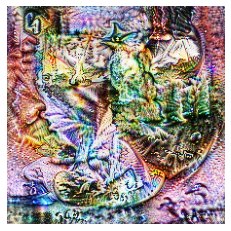

In [29]:
image().show()

  0%|          | 0/128 [00:00<?, ? step/s]

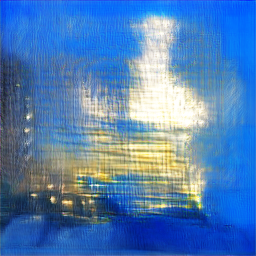

In [31]:
from prior_optimization import create_optimized_image, display_optimized_image

biggan_input, loss_history = create_optimized_image(target=target, channel=channel, n_steps=128)
display_optimized_image(biggan_input)

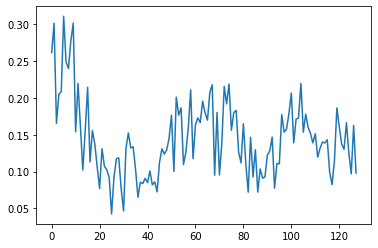

In [32]:
import matplotlib.pyplot as plt

plt.plot(loss_history.cpu().detach().numpy())